# Domain adaptation

In [1]:
from pathlib import Path
DATASET_ZIP_PATH = '/tmp/Adaptiope.zip'
DATASET_EXTRACTION_PATH = '/tmp/Adaptiope'
DATASET_PATH = Path('./data/adaptiope_small')

## Dataset extraction

In [2]:
from os import makedirs
from os.path import join, isdir
from shutil import copytree

In [3]:
!mkdir -p {DATASET_EXTRACTION_PATH}
!unzip -d {DATASET_EXTRACTION_PATH} {DATASET_ZIP_PATH}

unzip:  cannot find or open /tmp/Adaptiope.zip, /tmp/Adaptiope.zip.zip or /tmp/Adaptiope.zip.ZIP.


In [4]:
if not isdir(DATASET_PATH):
    classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
               "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
               "purse", "stand mixer", "stroller"]
    for d, td in zip([
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/product_images",
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/real_life"],[
        f"{DATASET_PATH}/product_images",
        f"{DATASET_PATH}/real_life"]):
        makedirs(td)
        for c in classes:
            c_path = join(d, c)
            c_target = join(td, c)
            copytree(c_path, c_target)

## Dataset exploration

In [5]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [6]:
dataset = ImageFolder(DATASET_PATH / "product_images")
idx_to_class = {v: k for k,v in dataset.class_to_idx.items()}

In [7]:
# imgs: List[str, int] path, class
seen_classes = set()
imgs = []
for i, (p, c) in enumerate(dataset.imgs):
    if c not in seen_classes:
        seen_classes.add(c)
        imgs.append(i)

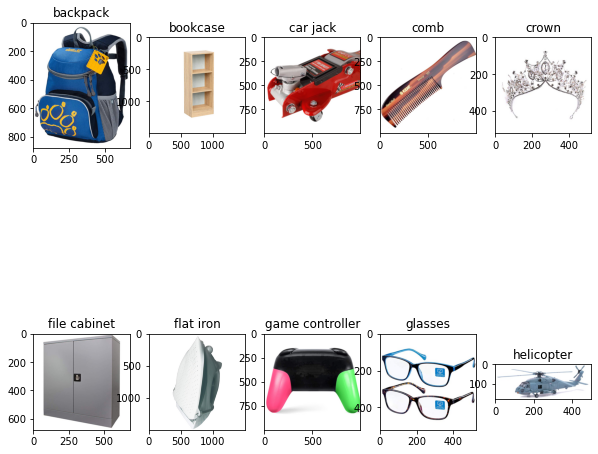

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(10,10))
for i in range(2):
    for j in range(5):
        image, title = dataset[imgs.pop(0)]
        axs[i,j].imshow(image)
        axs[i,j].set_title(idx_to_class[title])

## Utility functions

In [9]:
import random
import numpy as np
import torch

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

def set_random_seed(seed=0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def print_epoch_chart(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    epoch,
    num_epochs
):
    clear_output(wait=True)
    
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15,7))
    x = np.arange(len(train_losses))
    loss_ax.plot(x, train_losses, label='train')
    loss_ax.plot(x, val_losses, label='validation')
    loss_ax.set_title("Loss")
    loss_ax.set_ylim([0, 5])
    loss_ax.legend()
    acc_ax.plot(x, train_acc, label='train')
    acc_ax.plot(x, val_acc, label='validation')
    acc_ax.set_title("Accuracy")
    acc_ax.legend()
    fig.suptitle(f"Epoch {epoch+1} of {num_epochs}")
    plt.show()

## Losses

In [10]:
def coral(source_extracted_features, target_extracted_features, **kwargs):
    source = source_extracted_features.double()
    target = target_extracted_features.double()
    
    d = source.data.shape[1]
    ns, nt = source.data.shape[0], target.data.shape[0]
    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm / (ns - 1)

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt / (nt - 1)

    # frobenius norm between source and target
    loss = torch.mul((xc - xct), (xc - xct))
    loss = torch.sum(loss) / (4*d*d)
    return loss

## Models

All models are composed by three main elements:

- backbone
- feature processor
- classifier

The backbone is a pretrained network from `torchvision` trained with a smaller learning rate than the one used for other two components.
The feature extractor is used for process the output of the backbone, we decided to separate these two steps into two classes in order to have more control on both of them, this allow to make tests with many combinations.
The last element is the classifier, it is a simple linear layer that takes the output of backbone (feature processor if it is used) and return an array of prediction with the same length of the number of classes.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

from typing import Optional

In [12]:
class Backbone(nn.Module):
    def __init__(
        self,
        backbone_type: str,
    ) -> None:
        super(Backbone, self).__init__()
        if backbone_type == "resnet34":
            self.backbone = models.resnet34(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        else:
            raise ValueError("select one valid backbone_type")
            
        
    def get_output_num(self):
        return self.output_num
        
    def forward(self, x):
        return self.backbone(x)
    
class FeatureProcessor(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super(FeatureProcessor, self).__init__()
        self.processing_layer = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )
        self.output_num = output_size
        
    def get_output_num(self):
        return self.output_num
        
    def forward(self, x):
        return self.processing_layer(x)
    
class Classifier(nn.Module):
    def __init__(
        self,
        backbone_type: str,
        n_classes: int,
        n_feature_extracted: Optional[int] = None
    ) -> None:
        super(Classifier, self).__init__()
        self.backbone = Backbone(backbone_type)
        if n_feature_extracted:
            self.processing_features = True
            self.processing_layer = FeatureProcessor(self.backbone.get_output_num(), n_feature_extracted)
        else:
            self.processing_features = False
        self.classification_layer = nn.Linear(
            self.processing_layer.get_output_num() if self.processing_features else self.backbone.get_output_num(),
            n_classes
        )
        self.output_num = n_classes
        
    def get_output_num(self):
        self.output_num
        
    def get_features(self, x):
        features = self.backbone(x)
        if self.processing_features:
            features = self.processing_layer(features)
        return features
        
    def forward(self, x):
        features = self.get_features(x)
        classes = self.classification_layer(features)
        
        return features, classes

## Dataset

In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from torch.utils.data import DataLoader, random_split

In [14]:
source_dataset = ImageFolder(
    DATASET_PATH / "product_images",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)
target_dataset = ImageFolder(
    DATASET_PATH / "real_life",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

validation_ratio = .2
test_ratio = .2

validation_dataset, test_dataset, train_dataset = random_split(
    source_dataset,
    [
        int(len(source_dataset)*validation_ratio),
        int(len(source_dataset)*test_ratio),
        len(source_dataset) - (
            int(len(source_dataset)*validation_ratio)
            +int(len(source_dataset)*test_ratio)
        )
    ]
)

target_test_ratio = .4
target_test_dataset, target_train_dataset = random_split(
    target_dataset,
    [
        int(len(target_dataset)*target_test_ratio),
        len(target_dataset) - int(len(target_dataset)*target_test_ratio)
    ]
)

In [15]:
len(train_dataset), len(validation_dataset), len(test_dataset), len(target_train_dataset), len(target_test_dataset)

(1200, 400, 400, 1200, 800)

## Train

In [16]:
from torch.optim import lr_scheduler, SGD, Adam

from tqdm import tqdm
#import torchinfo

In [17]:
# misc
set_random_seed(33)
device = get_device()
num_threads = 4

# train
num_epochs = 30
batch_size = 32
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20

# domain adaptation loss
use_coral = True
coral_weight = 20

In [18]:
def get_data_loader(dataset, batch_size, num_threads):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_threads
    )

def get_optimizer(model, lr, wd, momentum):
    higher_lr_weights = []
    lower_lr_weights = []

    for name, param in model.named_parameters():
        if name.startswith('backbone'):
            lower_lr_weights.append(param)
        elif name.startswith('processing') or name.startswith('classification'):
            higher_lr_weights.append(param)
        else:
            raise ValueError(f"Unexpected type of weights {name}")

    optimizer = torch.optim.SGD(
        [
            {'params': lower_lr_weights},
            {'params': higher_lr_weights, 'lr': lr}
        ],
        lr=lr / 10,
        weight_decay=wd,
        momentum=momentum
    )

    return optimizer

In [19]:
model = Classifier(
    backbone_type="resnet34", 
    n_classes=len(dataset.classes),
    # n_feature_extracted=2048
)
model.to(device)
optimizer = get_optimizer(model, lr, weight_decay, momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    verbose=True
) 
dataloaders = {
    'train': {
        'source': get_data_loader(train_dataset, batch_size, num_threads),
        'target': get_data_loader(target_train_dataset, batch_size, num_threads),
    },
    'validation': {
        'source': get_data_loader(validation_dataset, batch_size, num_threads),
    }
    #'test': get_data_loader(test_dataset, batch_size, num_threads)
}
#summary(model, input_size=(batch_size, *dataset[0][0].size()))

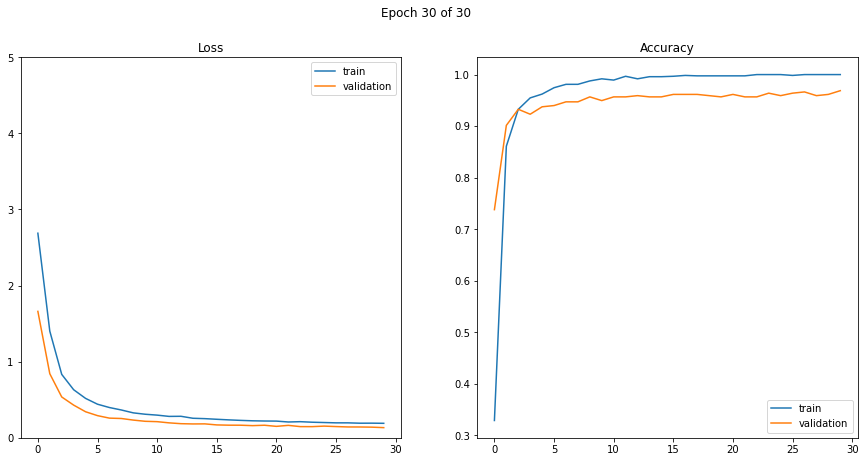

In [20]:
best_model = model
best_loss = np.Inf

phases_loss = {k: [] for k in dataloaders.keys()}
phases_acc = {k: [] for k in dataloaders.keys()}
for epoch in range(num_epochs):
    for phase, phase_dataloaders in dataloaders.items():
        source_dataloader = phase_dataloaders['source']
        target_dataloader = phase_dataloaders.get('target', None)
        if phase == "train":
            model.train()
        else:
            model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        for index, (x, labels) in enumerate(source_dataloader):
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.autocast(device_type=device.type):
                with torch.set_grad_enabled(phase == "train"):
                    features, predictions = model(x)
                    x = x.detach().cpu()
                    
                    loss = criterion(predictions, labels)
                    predictions = predictions.detach().cpu()
                    labels = labels.detach().cpu()
                    if use_coral and not target_dataloader is None:
                        source_feauteres = features.cpu()
                        target_x, _ = next(target_dataloader._get_iterator())
                        target_x = target_x.to(device)
                        target_fuatures, _ = model(target_x)
                        target_x = target_x.detach().cpu()
                        target_fuatures = target_fuatures.cpu()
                        loss = loss + coral_weight * coral(source_feauteres, target_fuatures)
                    epoch_loss += loss.item()
                    epoch_acc += (torch.argmax(predictions, 1) == labels).sum().item() / labels.size()[0]

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

        epoch_loss /= len(source_dataloader)
        epoch_acc /= len(source_dataloader)
        phases_loss[phase].append(epoch_loss)
        phases_acc[phase].append(epoch_acc)

        if phase == "validation" and abs(epoch_loss) <= abs(best_loss):
            best_model = model
            best_loss = epoch_loss
            scheduler.step(epoch_loss)
            
    print_epoch_chart(
        phases_loss['train'],
        phases_loss['validation'],
        phases_acc['train'],
        phases_acc['validation'],
        epoch,
        num_epochs
    )

### Test model

In [21]:
predictions = []
reals = []
for x, y in test_dataset:
    x_gpu = x.unsqueeze(0).to(device)
    _, predicted = best_model(x_gpu)
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
predictions = np.array(predictions)
reals = np.array(reals)

In [22]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

stroller stroller


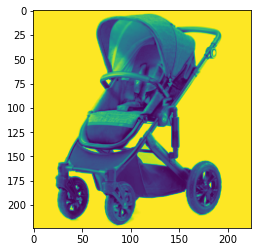

In [23]:
plot_predictions(350, idx_to_class, test_dataset, reals, predictions) 

In [24]:
(reals == predictions).sum() / reals.shape[0]

0.97

## Domain adaptation

### Plain

In [25]:
predictions = []
reals = []
for x, y in target_dataset:
    x_gpu = x.unsqueeze(0).to(device)
    _, predicted = best_model(x_gpu)
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
predictions = np.array(predictions)
reals = np.array(reals)

In [26]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

comb comb


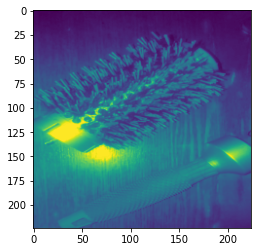

In [27]:
plot_predictions(350, idx_to_class, target_dataset, reals, predictions) 

In [28]:
(reals == predictions).sum() / reals.shape[0]

0.816